# Classification

## MNIST

### Load dataset

In [22]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

print(f"features size: {X_mnist.shape}\nlabels size:{y_mnist.shape}")

features size: (70000, 784)
labels size:(70000,)


### Visualize data

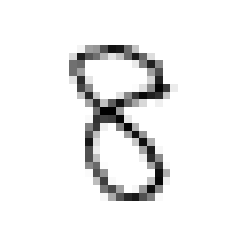

In [23]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

X, y = X_mnist, y_mnist

some_digit = X[3600]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
           interpolation='nearest')
plt.axis('off')
plt.show()

In [24]:
print(f"This is number: {y[3600]}")

This is number: 8


### Split data into train and test set

In [25]:
from sklearn.model_selection import train_test_split
from sklearn import random

random.seed(2910)

X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True,train_size=0.9 ,random_state=2910)


print(f"Train size: {X_train.shape}, {y_train.shape}")
print(f"Test size: {X_test.shape}, {y_test.shape}")


Train size: (63000, 784), (63000,)
Test size: (7000, 784), (7000,)


## Training a Binary Classifier

Đưa bài toán trở về đơn giản với binary classifier, xác định đâu là số 8.

In [26]:
y_train_8 = (y_train == '8')
y_test_8= (y_test == '8')


In [27]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=2910)
sgd_clf.fit(X_train, y_train_8)


SGDClassifier(random_state=2910)

### Make prediction with image show above

In [28]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring accuracy using cross-validation

Sử dụng `StratifiedKfold`

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=2910, shuffle=True)

for train_idx, test_idx in skfolds.split(X_train, y_train_8):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_idx]
    y_train_folds = y_train_8[train_idx]
    
    X_test_folds = X_train[test_idx]
    y_test_folds = y_train_8[test_idx]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    
    print(n_correct / len(y_pred))
    

0.9330952380952381
0.9221428571428572
0.9268095238095239


Sử dụng `cross_val_score`

In [30]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_8, cv=3, scoring='accuracy')

array([0.93833333, 0.92771429, 0.92390476])

Có một vấn đề là độ chính xác (accuracy) không phải là một cách đánh giá performance nên được dùng của một classifier. Lấy ví dụ ta sẽ sử dụng một classifier luôn luôn cho ra dự đoán là dữ liệu này chính là số 8.

Cùng xem qua tập dữ liệu:

In [31]:
print(f"Number of 8 class: {sum(y_train_8)}")
print(f"Number of not 8 class: {len(y_train_8) - sum(y_train_8)}")

print(f"Ratio of num_8/total = {1- sum(y_train_8)/len(y_train_8)}")

Number of 8 class: 6152
Number of not 8 class: 56848
Ratio of num_8/total = 0.9023492063492063


Như vậy ta có tỷ lệ các số không phải là 8 tầm 90%

Bây giờ ta sẽ viết classifier luôn luôn cho ra dự đoán dữ liệu chính là số 8

In [32]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
import numpy as np


class NeverEightClf(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
    
    
never_8_clf = NeverEightClf()

cross_val_score(never_8_clf, X_train, y_train_8, cv=3, scoring='accuracy')

array([0.90119048, 0.899     , 0.90685714])

Accuracy thu được là 90%, điều này là hiển nhiên vì như ta đã thấy từ đầu là có 90% data không phải 8 và 10% là số 8. Như vậy model luôn dự đoán data không phải là 8 thì đương nhiên sẽ có ít nhất là 90% accuracy

### Confusion Matrix

Một cách tốt hơn để có thể đánh giá hiệu năng của `classifier` là nhìn vào `confusion matrix`. Ý tưởng là đếm số lần mà class A bị classified nhầm thành class B. Ví dụ, để biết số lần bị phần biệt nhầm của 5s thành 3s thì ta sẽ nhìn vào dòng thứ 5, cột 3 của confusion matrix.

Để tạo ra confusion matrix, đầu tiên thì cần phải có list của các predictions đã tạo ra để có thể so sánh với kết quả thực tế.

Hàm `cross_val_predict` giống với `cross_val_score` nhưng chúng khác nhau ở giá trị trả về:

- `cross_val_predict` trả về giá trị predictions
- `cross_val_score` trả về accuracy

In [33]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_8, cv=3)

In [34]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_8, y_train_pred)

array([[56043,   805],
       [ 3606,  2546]], dtype=int64)

Ý nghĩa của `confusion matrix` trên là:

- Mỗi dòng biểu diễn cho `actual class` và mỗi cột biểu diễn `predicted class`

#     | predicted as non-5s | predicted as 5s
------|---------------------|-----------------
non-5s|56043                |805
5s    |3606                 |2546

Ta có tất cả 63000 điểm dữ liệu:

- 56848 điểm là không phải class 5
- 6152 điểm là class 5

- Đối với 56848 điểm không phải class 5, khi đưa vào mô hình thì ta được dự đoán đúng 56043 điểm và 805 điểm bị dự đoán sai

- Đối với 6152 điểm là class 5, khi đưa vào mô hình ta được dự đoán đúng 2546 điểm và 3606 điểm bị dự đoán sai

=> Cột predicted as non-5s:  negative prediction

=> Cột predicted as 5s    :postitive prediction

Như vậy nếu như predicted class là hoàn hảo => Ta sẽ có confusion matrix dạng như sau:

#     | predicted as non-5s | predicted as 5s
------|---------------------|-----------------
non-5s|56848                |0
5s    |0                    |6152

Tức `confusion matrix` cho 100% predicted đúng sẽ là ma trận đường chéo

### Precision và Recall

- Precision được gọi là độ chính xác của mô hình nói tỉ lệ số điểm positive mô hình dự đoán đúng trên tổng số điểm dự đoán là positive
- Recall là độ nhạy của mô hình nói lên tỉ lệ số điểm positive  dự đoán đúng trên tổng số điểm thực sự là positive

#### Precision

Giá trị biểu diễn accuracy của positive prediction được gọi là `precision` của classifier

precision =$\frac{TP}{TP + FP}$

- TP là số prediction đúng của positive prediction
- FP là số prediction sai của positive prediction

#### Recall

Còn được gọi là `sensivity` hay `true positive rate` (Độ nhạy)

recall = $\frac{TP}{TP + FN}$

- FN là số prediction sai của negative prediction

![](../../../imgs/precision_recall.png)

* Vị trí: hàng - cột

- Như vậy confusion matrix có dạng như trên, với các số ở vị trí negative-negative được gọi là true negatives.

- Với các số ở vị trí negative-positive thì được gọi là false positives

- Với các số ở vị trí positives-positive thì được gọi là true positives

- Với các số ở vị trí positive-negative thì được gọi là false positives



In [35]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_8, y_train_pred))

print(recall_score(y_train_8, y_train_pred))

0.759773202029245
0.4138491547464239


### F1 score

Ta dùng F1 score như là sự kết hợp của cả precision và recall để so sanh giữa các model

![](../../../imgs/f1.png)

In [36]:
from sklearn.metrics import f1_score

f1_score(y_train_8, y_train_pred)

0.5358307902767547

Tuy nhiên không phải lúc nào cũng dùng `F1 score` để đánh giá model. Trong một số trường hợp, thứ mà ta quan tâm nhiều nhất là `precision`, nhưng trong trường hợp khác ta lại quan tâm nhiều nhất là `recall`.

Ví dụ: Nếu như ta cần training một classifier để xác định video nào an toàn cho trẻ em, hiển nhiên là ta sẽ muốn một classifier mà có khả năng nhận diện ra video xấu lớn => TP lớn, FP nhỏ => precision lớn và recall nhỏ

Và hiển nhiên là ta không thể nào có lợi được cả về recall và precision, ta chỉ có thể đánh đổi một bên để cho bên kia được tố nhất. Vậy cho nên ta có định nghĩa `precision/recall tradeoff`


### Precision/Recall Tradeoff

Để hiểu định nghĩa ta sẽ xem `SGDClassifier` thực hiện classification decisions thế nào. Với mỗi số, nó sẽ tính toán một score dựa trên `decision function` và nếu như score này lớn hơn threshold, số đó sẽ được gán cho `positive class` và ngược lại gán cho `negative class`. Giả sử threshold được đặt ở mũi tên chính giữa ta có hình sau

![](../../../imgs/trade_off_1.png)

Ta thấy răng các số ở bên phải của decision-threshold được gán là positive class, các số ở bên trái là negative class.

Như vậy ta sẽ có 4 số 5 là `true positive`, một số 6 là `false positive` => tính được precision là 4/5. Tổng cộng ta có sáu số 5 cần classified, trong đó có 4 số là detect đúng => recall = 4/6

Bây giờ nếu như ta thay đổi decision-threshold sang bên phải:

- Có 3 số thì cả 3 số đều là 5 => true positive => precision = 3/3 
- recall = 3/6

Nếu đổi decision-threshold sang bên trái thì:

- precision = 6/8
- recall - 6/6

sklearn không cho ta set threshold một cách trực tiếp nhưng cho cho ta hàm tính toán và trả về decision score. Từ decision score ta có thể apply threshold tự định nghĩa để gán class cho data.

In [37]:
y_scores = sgd_clf.decision_function([some_digit])

print(y_scores)

threshold = 0

y_some_digit_pred = (y_scores > threshold)

print(y_some_digit_pred)


[950.70310311]
[ True]


In [38]:
threshold = 200000

y_some_digit_pred = (y_scores > threshold)

print(y_some_digit_pred)

[False]


Ta thấy răng threshold càng tăng thì recall càng giảm.

Ta có thể biết được là nên dùng giá trị nào của threshold bằng cách dùng `cross_val_predict()` nhưng bây giờ sẽ không trả về giá trị predcit mà trả về kết quả của `decision scores`. 

In [39]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_8,
                             cv=3, method='decision_function')

Với các giá trị `decision_scores` thu được ta có thể thực hiện tính toán `precision và recall` cho tất cả các trường hợp threshold với hàm `precision_recall_curve()` function:

(63001,)
(63000,)


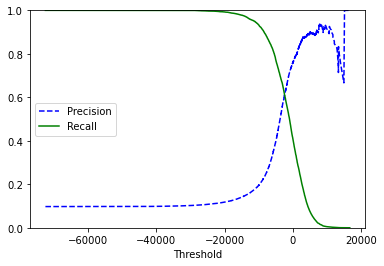

In [45]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_8, y_scores)


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Từ đồ thị ta có thể thấy mối quan hệ giữa threshold đối với recall và precision

- Khi threshold tăng thì recall luôn luôn giảm
- Khi threshold tăng thì precision có thể tăng hoặc cũng có thể giảm

Bây giờ thì ta có thể chọn được threshold sao cho phù hợp với `precision/recall` tradeoff

Một cách khác nữa để chọn 2 giá trị `precision và recall` theo ý muốn đó là vẽ ra đồ thị phụ thuốc của precision vào recall

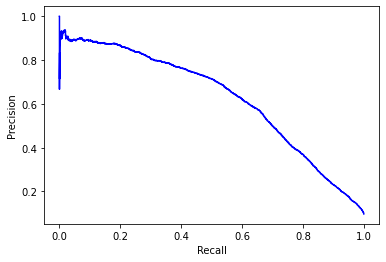

In [46]:
plt.plot(recalls[:-1], precisions[:-1],"b-")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

Bây giờ ví dụ ta muốn đạt được 90% precision, nhìn vào plot thứ nhất mqh giữa precision, recall và threshold. Ta thấy răng ta sẽ cần giá trị threshold là vào khoảng 10,000

In [49]:
y_train_pred_90 = (y_scores > 10000)

print(precision_score(y_train_8, y_train_pred_90))

print(recall_score(y_train_8, y_train_pred_90))

0.9142857142857143
0.005201560468140442


### ROC Curve

Viết tắt của `receiver operating characteristic` (ROC). Đường này giống với đường precision/recall, nhưng thay vì plot ra precision theo recall, ROC curve plots `true positive rate` (tên gọi khác của recall) theo `false positive rate`.

- Thông số FPR là tỉ lệ của negative class bị classified nhầm thành positive. FPR = 1 - `true negative rate` (True negative rate là tỉ số các class negative được classified đúng là negative)
- Thông số TNR còn được gọi là `specifity`.

ROC curve plots `sensivity` (recall) versus `1 - specifity`



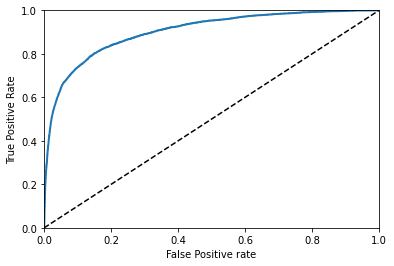

In [51]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_8, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

## Multiclass Classification

Thường thì ta có thể sử dụng một số classifier sau đây để phân loại trực tiếp nhiều class:

- Random Forest 
- Naive bayes

Một số loại sau thì strictly dùng cho phân loại 2 class (binary classification):

- Support Vector Machine
- Linear classifier

Tuy nhiên ta có thể kết hợp các bộ binary classifier để có được 1 bộ multinomial classifier bằng cách Như sau. Ví dụ cần phân biệt các số từ 0-9. Ta sẽ sử dụng 10 bộ classifier lần lượt là:

- Bộ classifier digit 0 và không phải digit 0
- Bộ classifier digit 1 và không phải digit 1

...

- Bộ classifier digit 9 và không phải digit 9

Sau đó khi ta muốn classify image, ta sẽ lấy ra decision score từ mỗi classifier và sau đó gán label cho ảnh theo class mà có decision score cao nhất. Đây gọi là `one-versus-all` (OvA) hay còn gọi là `one-versus-rest`.



Một cách khác đó là ta sẽ train binary classifier để phân biệt các cặp digits: phân biệt digit 0 và 1, phân biệt digit 0 và 2, ... Đây gọi là `one-versus-one` (OvO). Nếu như ta có `N` classes, vậy ta sẽ cần `Nx(N-1)/2` classifiers. Ví dụ cho MNIST là có 10 classes => có 10x(10-1)/2 = 45 bộ classifiers. Lợi ích của việc dùng `strategy OvO` này là ta chỉ cần training mỗi classifier trên tập data chỉ gồm 2 digits cần classifier thôi chứ không phải toàn bộ tập train data.

Với hầu hết các classification algorithms thì `OvA` hay được dùng hơn. Tuy có SVM thì hay dùng `OvO`

Sklearn sẽ tự xác định xem khi ta sử dụng `binary classification` cho `multi-class classification` thì nó sẽ chạy `OvA` trừ với SVM thì nó sẽ chạy `OvO`.

## Error Analysis

Nếu như theo các bước ở [Appendix B: exploring data preparation options](../Appendix_ML_project_checklist.md) thì ta sẽ thử nhiều models, tìm ra model tốt nhất với `GridSearchCV`.

Giả sử như ta đã tìm ra được model mong muốn và ta muốn tìm cách để cải thiện nó. Có một cách đó là phân tích loại lỗi mà model gặp phải.

Đầu tiên thì ta có thể nhìn vào `confusion matrix`. Sử dụng hàm `cross_val_predict()` để tính ra prediction cho tập dữ liệu, sau đó gọi hàm `confusion_matrix` để tính toán

In [52]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

conf_mx

array([[6112,    0,   13,   10,    3,   14,   11,    2,   41,   10],
       [   8, 6699,   42,   35,    8,   38,   13,   12,  184,   26],
       [ 146,   50, 5501,  117,   65,   40,   59,   82,  219,   20],
       [ 120,   34,  179, 5493,    9,  331,    9,   46,  167,   80],
       [  64,   22,   65,   35, 5361,   20,   40,   26,  149,  387],
       [ 227,   30,   39,  353,   81, 4273,   76,   34,  412,  145],
       [ 152,   16,  148,   34,   32,  147, 5466,    4,  174,    6],
       [  58,   22,   72,   44,   66,   20,    4, 5798,   72,  377],
       [ 163,   96,  173,  247,   42,  450,   41,   32, 4742,  166],
       [  78,   24,   35,  104,  246,   57,    1,  166,  255, 5283]],
      dtype=int64)

Ta có thể tận dụng giá trị pixel ảnh càng lớn thì màu sắc càng gần màu trắng để đổi ma trận số trên thành ma trận ảnh để có cái nhìn hay hơn về confusion matrix với hàm `plt.matshow`

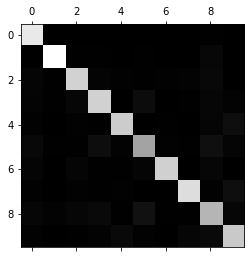

In [53]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Với màu sắc của ma trận ảnh trên ta có thể thấy răng các class đã được classified khá đúng vì màu sắc tại đường chéo là màu gần trắng. Nhìn vào class 5 thì có vẻ như tối hơn so với các class còn lại thì ta có thể nhận xét rằng classifier đang không thực hiện tốt lắm trên class 5 hoặc cũng có thể class 5 có số lượng ít hơn so với các class còn lại.

Ta có thể kiểm tra cả 2 case trên với class 5.

Đầu tiên, ta sẽ chia các giá trị của ma trận cho số lượng images thuộc về mỗi class ( chính là tổng các dòng).

In [55]:
row_sums = conf_mx.sum(axis=1, keepdims=True)

print(row_sums)

norm_conf_mx = conf_mx / row_sums

[[6216]
 [7065]
 [6299]
 [6468]
 [6169]
 [5670]
 [6179]
 [6533]
 [6152]
 [6249]]


Tiếp theo ta sẽ tô đen đường chéo (tức các class phần loại đúng) và chỉ giữ lại error

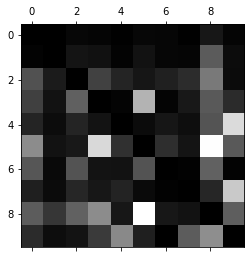

In [56]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Multilabel Classification

## Multiouput Classification